# Pipeline of Digits

This is a starting notebook for solving the "Pipeline of Digits" assignment.


This notebook was created by [Santiago L. Valdarrama](https://twitter.com/svpino) as part of the [Machine Learning School](https://www.ml.school) program.

## Step 1 - Prepare the MNIST Dataset

MNIST is a popular and relatively small dataset, so it's easy to find pre-packaged versions of it. We aren't going to use those. Instead, we will simulate a practical scenario where the data is stored in the filesystem. To accomplish this, you will load a pre-packaged version of MNIST, save it to disk, and upload it to an S3 bucket.

These are the steps you need to follow to prepare the data:

1. Create the S3 bucket to upload the dataset.
2. Load the MNIST dataset from the Keras built-in collection of small datasets, convert it into images, and save them to the disk.
3. Upload the dataset to the S3 bucket.


In [4]:
!pip install -q --upgrade awscli
!pip install -q --upgrade pip
!pip install -q --upgrade sagemaker

!pip install -q tdqm

!pip show -q sagemaker

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.20.22 requires botocore<1.24.0,>=1.23.22, but you have botocore 1.29.120 which is incompatible.
boto3 1.20.22 requires s3transfer<0.6.0,>=0.5.0, but you have s3transfer 0.6.0 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [4]:
%load_ext autoreload
%autoreload 2

### Creating the dataset

We want to load the Keras' built-in version of MNIST and save it to disk so we can later upload it to S3.

There are 70,000 images. Running this cell will take some time, so this is the perfect moment to walk around and grab some coffee. Fortunately, we only need to do this once.

In [5]:
import numpy as np
import tensorflow as tf

from PIL import Image
from pathlib import Path
from tqdm import tqdm
from tensorflow.keras.datasets import mnist


def save(dataset, split, images, labels):
    """
    This function saves the handwritten digits to disk as PNG files.
    
    Every image will be saved inside a folder corresponding to 
    its label. For example, a digit from the train set representing 
    the number 3 will be saved inside the folder `~/train/3`.
    """
    
    for index, (image, label) in enumerate(tqdm(zip(images, labels), total=len(images), desc="Processing images")):
        im = Image.fromarray(image)

        path = dataset / split / str(label)
        path.mkdir(parents=True, exist_ok=True)
        
        im.save(path / f"{index}.png")
        

# We will save the dataset in the home directory, inside a folder
# named `dataset`.
dataset = Path.home() / "ml.school" / "mnist" / "dataset"

# We want to make sure we don't generate the images if the dataset
# already exists.
if not dataset.exists():
    # Load the MNIST dataset using the Keras library. This returns the
    # dataset in numpy arrays.
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Use the function we created to save the data to disk.
    save(dataset, split="train", images=X_train, labels=y_train)
    save(dataset, split="test", images=X_test, labels=y_test)

In [15]:
# david: count the amount of images in dataset
!find $dataset -type f | wc -l

70000


### Uploading the data to S3

Now that we exported the MNIST dataset to the filesystem, we need to upload them to an S3 bucket. The easiest way to do this is to use the AWS CLI.

This command will also take a while to finish.

In [9]:
# david: check available buckets
!aws s3 ls

2023-04-19 07:51:28 mlschool-davidorti
2023-04-18 17:40:20 sagemaker-eu-west-1-833724363691
2023-04-18 17:24:20 sagemaker-studio-16plxrf7g0e
2023-04-18 17:35:35 sagemaker-studio-833724363691-w118blftrin


In [6]:
# david: previously created bucket (for penguins asignment)
BUCKET = "mlschool-davidorti"

MNIST_FOLDER = "mnist"

S3_FILEPATH = f"s3://{BUCKET}/{MNIST_FOLDER}"
LOCAL_FILEPATH = dataset

In [11]:
!aws s3 cp $dataset $S3_FILEPATH --recursive --quiet

## Step 2 – Getting Started

Importing needed libraries, defining AWS main parameters.

#### uTo-Do:
* Remove not needed imports
* Understand baseline generation: `generate_baseline`

In [7]:
import os
import sagemaker
import numpy as np
import boto3
import json
import pandas as pd
import numpy as np
import urllib.request
import argparse
import tempfile
from pathlib import Path

import tensorflow as tf

from botocore.exceptions import ClientError
from sagemaker.inputs import FileSystemInput
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.processing import ScriptProcessor
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.workflow.parameters import ParameterInteger, ParameterString, ParameterFloat
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import CacheConfig


role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sagemaker_session = sagemaker.session.Session()

## Step 3 – Preprocessing the Dataset

In [9]:
%%writefile {MNIST_FOLDER}/preprocessor.py

import os
import numpy as np
import pandas as pd
import tempfile

from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pickle import dump


# This is the location where the SageMaker Processing job
# will save the input dataset.
BASE_DIR = "/opt/ml/processing"
DATA_FILEPATH = Path(BASE_DIR) / "input" / "data.csv"


# david: this 
def preprocess(base_dir, date_filepath):
    """
    Preprocesses the supplied raw dataset and splits it into a train, validation,
    and test set.
    """
    
    

Writing mnist/preprocessor.py


In [24]:
# david: attempt to open images

folder_path = dataset / "train" / "1"

# List all files and directories in the folder
all_items = os.listdir(folder_path)

# Filter out directories to get only files
files = [
    item for i, item in enumerate(all_items)
    if os.path.isfile(folder_path / item) and i < 5
]

print(files)

['49817.png', '56783.png', '51779.png', '15977.png', '21109.png']


In [8]:
folder_path = dataset / "train" / "1"

all_items = os.listdir(folder_path)

# all files in given class ("1")
files = [
    item for i, item in enumerate(all_items)
    if os.path.isfile(folder_path / item) and i < 5
]
print(files)

# all classes ("0" to "9")
digits = [
    item for item in os.listdir(dataset / "train")
    if os.path.isdir(dataset / "train" / item)
]
digits.sort()
print(digits)

['49817.png', '56783.png', '51779.png', '15977.png', '21109.png']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


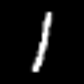

In [25]:
image_path = dataset / "train" / "1" / files[4]
image = Image.open(image_path)

width, height = image.size
new_width = int(width * 3)
new_height = int(height * 3)
resized_image = image.resize((new_width, new_height))

resized_image.show()

In [26]:
array = np.asarray(image)
print(array)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 110 253  46
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 161 252  45
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  17 228 252  45
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 118 252 227  29
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 138 25

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder



split_sets = ["train", "test"]

for split_set in split_sets:
    digits = [item for item in os.listdir(dataset / split_set) if os.path.isdir(dataset / split_set / item)]
    arrays, labels = [], []
    for digit in tqdm(digits, total=len(digits), desc=f"Processing {split_set} digits"):
        digit_folder = dataset / split_set / digit
        files = [item for i, item in enumerate(os.listdir(digit_folder)) if os.path.isfile(Path(digit_folder) / item) and i<6]
        for i in files:
            image_path = dataset / split_set / digit / i
            image = Image.open(image_path)
            array = np.asarray(image)
            arrays.append(array)

            labels.append(int(digit))

    stacked_arrays = np.stack(arrays, axis=0)
    labels = np.array(labels)

    if split_set == "train":
        # assumption: there are enough images so split per class will be evenly distr. after shuffling
        X_train, X_validation, y_train, y_validation = train_test_split(
            stacked_arrays,
            labels,
            test_size=0.16,#test_size=10000,
            shuffle=True
        )
        print(f"{len(X_train)=}, {len(y_train)=}")
        print(f"{len(X_validation)=}, {len(y_validation)=}")
    else:
        X_test, y_test = arrays, labels
        print(f"{len(X_test)=}, {len(y_test)=}")
    


array_preprocessor = Pipeline(steps=[
    ("scaler", MinMaxScaler(feature_range=(0, 1)))
])

categorical_preprocessor = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

#preprocessor = XTransformer

Processing train digits: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


len(X_train)=50, len(y_train)=50
len(X_validation)=10, len(y_validation)=10


Processing test digits: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]

len(X_test)=60, len(y_test)=60


In [18]:
X_train.shape

(60, 28, 28)

In [87]:
print(np.array(labels).shape)

(30,)


## Step 4 – Testing the Preprocessing Step

In [65]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [89]:
y_train.shape

(60000,)

In [88]:
type(y_train)

numpy.ndarray

In [33]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)